In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
import plotly.plotly as py

import os
print(os.listdir("./"))
# video level feature file
print(os.listdir("./video_sample"))
# frame level features file
print(os.listdir("./frame_sample"))

['label_names_2018.csv', 'video_sample', '.DS_Store', 'vocabulary.csv', 'GCP-Credits.rtf', 'frame_validation', 'checkpoints', 'video_test', 'frame_test', 'frame_sample', 'classifier.ipynb', 'video_validation', '.idea']
['train0208.tfrecord', 'train01.tfrecord', 'train00.tfrecord']
['train0208.tfrecord', 'train01.tfrecord', 'train00.tfrecord']


## Problem Understanding

The YouTube8M challenge is a multi-class classification problem, where we are asked to predict for each video, given video & frame level audio and frame RGB features, to which group of categories it belongs to.

I have divided entire task into two parts

1. Simple Data Exploration,  Labels/classes study of sample videos. 
2. Created a Bi-LSTM multilabel neural model by randomly created sample data.

Lets first explore the labels for the training data, their distribution and frequent patterns and co-occurance of the most frequent label categories.

**Since we have been given sample dataset  here, so all my exploration will be done on sample data, we can do the same anlaysis on large corpus using GCloud ML Engine**

## Labels and their distributons

In [6]:
# total number of labels
labels_df = pd.read_csv('./label_names_2018.csv')
print(labels_df.head())
print("Total nubers of labels in sample dataset: %s" %(len(labels_df['label_name'].unique())))

   label_id  label_name
0         0        Game
1         1     Vehicle
2         2  Video game
3         3     Concert
4         4         Car
Total nubers of labels in sample dataset: 3807


## Video Level data

In [9]:
# distribution of labels
video_files = ["./video_sample/{}".format(i) for i in os.listdir("./video_sample")]
print(video_files)

vid_ids = []
labels = []
mean_rgb = []
mean_audio = []

for file in video_files:
    for example in tf.python_io.tf_record_iterator(file):
        tf_example = tf.train.Example.FromString(example)

        vid_ids.append(tf_example.features.feature['id'].bytes_list.value[0].decode(encoding='UTF-8'))
        labels.append(tf_example.features.feature['labels'].int64_list.value)
        mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
        mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)

print('Number of videos in Sample data set: %s' % str(len(vid_ids)))
print('Picking a youtube video id: %s' % vid_ids[13])
print('List of label ids for youtube video id %s, are - %s' % (vid_ids[13], str(labels[13])))
print('First 20 rgb feature of a youtube video (',vid_ids[13],'): are - %s' % str(mean_rgb[13][:20]))

['./video_sample/train0208.tfrecord', './video_sample/train01.tfrecord', './video_sample/train00.tfrecord']


Number of videos in Sample data set: 3059
Picking a youtube video id: tedw
List of label ids for youtube video id tedw, are - [2, 7, 83]
First 20 rgb feature of a youtube video ( tedw ): are - [-1.3979190587997437, 1.3181191682815552, -0.6727305054664612, 0.6157562136650085, 0.4521563947200775, 0.4070080816745758, 0.07166368514299393, 0.06130671873688698, -0.18977423012256622, 0.13159328699111938, 0.09810913354158401, -0.32069429755210876, 0.18438364565372467, 0.3411458432674408, 0.8093208074569702, 0.08855659514665604, -0.13296176493167877, -0.7093318104743958, 0.5643736124038696, -0.08529961854219437]


In [10]:
#MOST COMMON LABELS
# Lets convert labels for each video into their respective names
labels_name = []
for row in labels:
    n_labels = []
    for label_id in row:
        # some labels ids are missing so have put try/except
        try:
            n_labels.append(str(labels_df[labels_df['label_id']==label_id]['label_name'].values[0]))
        except:
            continue
    labels_name.append(n_labels)

print('List of label names for youtube video id %s, are - %s' % (vid_ids[13], str(labels_name[13])))

List of label names for youtube video id tedw, are - ['Video game', 'Musician', 'Skateboarding']


In [12]:
# creating labels count dictionary
from collections import Counter
import operator

all_labels = []
for each in labels_name:
    all_labels.extend(each)

labels_count_dict = dict(Counter(all_labels))

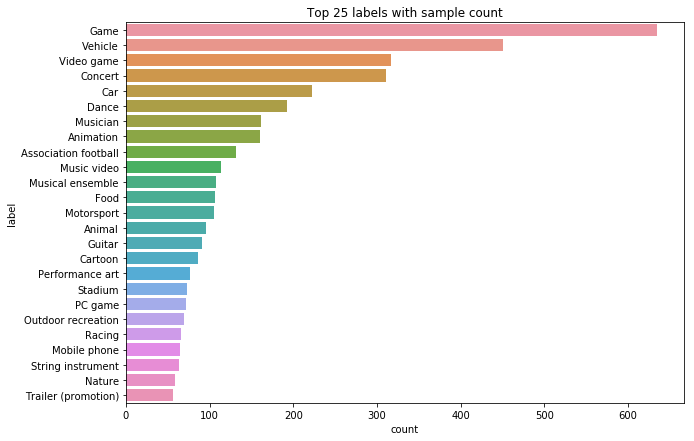

In [13]:
# creating label count dataframe
labels_count_df = pd.DataFrame.from_dict(labels_count_dict, orient='index').reset_index()
labels_count_df.columns = ['label', 'count']
sorted_labels_count_df = labels_count_df.sort_values('count', ascending=False)

# plotting top 25 labels distribution
TOP = 25
TOP_labels = list(sorted_labels_count_df['label'])[:TOP]
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(y='label', x='count', data=sorted_labels_count_df.iloc[0:TOP, :])
plt.title('Top {} labels with sample count'.format(TOP))

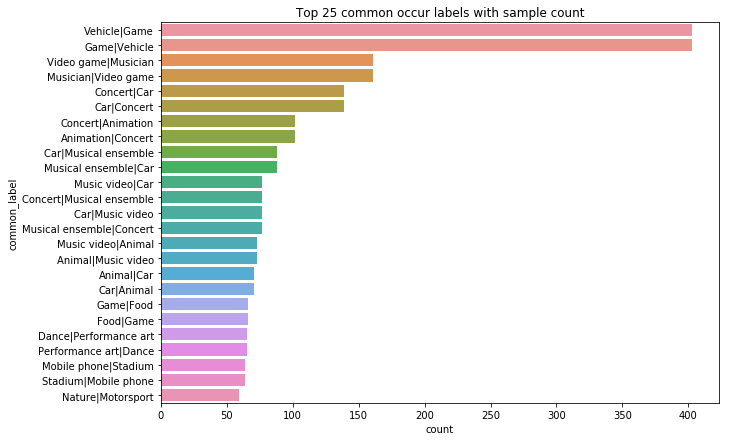

In [15]:
# creating common occurs labels count dict
common_occur_top_label_dict = {}
for row in labels_name:
    for label in row:
        if label in TOP_labels:
            c_labels = [label + "|" + x for x in row if x != label]
            for c_label in c_labels: 
                common_occur_top_label_dict[c_label] = common_occur_top_label_dict.get(c_label, 0) + 1

# creating dataframe
common_occur_top_label_df = pd.DataFrame.from_dict(common_occur_top_label_dict, orient='index').reset_index()
common_occur_top_label_df.columns = ['common_label', 'count']
sorted_common_occur_top_label_df = common_occur_top_label_df.sort_values('count', ascending=False)


# plotting 25 common occurs labels from top labels
TOP = 25
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(y='common_label', x='count', data=sorted_common_occur_top_label_df.iloc[0:TOP, :])
plt.title('Top {} common occur labels with sample count'.format(TOP))

## Frame level data

In [18]:
#Frame level data
frame_files = ["./frame_sample/{}".format(i) for i in os.listdir("./frame_sample")]
feat_rgb = []
feat_audio = []


for file in frame_files:
    for example in tf.python_io.tf_record_iterator(file):        
        tf_seq_example = tf.train.SequenceExample.FromString(example)
        n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
        sess = tf.InteractiveSession()
        rgb_frame = []
        audio_frame = []
        # iterate through frames
        for i in range(n_frames):
            rgb_frame.append(tf.cast(tf.decode_raw(
                    tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                           ,tf.float32).eval())
            audio_frame.append(tf.cast(tf.decode_raw(
                    tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                           ,tf.float32).eval())


        sess.close()
        feat_rgb.append(rgb_frame)
        feat_audio.append(audio_frame)
        break

In [19]:
print("No. of videos %d" % len(feat_rgb))
print('The first video has %d frames' %len(feat_rgb[0]))
print("Max frame length is: %d" % max([len(x) for x in feat_rgb]))

No. of videos 3
The first video has 265 frames
Max frame length is: 265


## Bigram LSTM
<img src="model.png" alt="model">

### We will try Context Gating
Miech, Antoine, Ivan Laptev, and Josef Sivic. "Learnable pooling with Context Gating for video classification." arXiv preprint arXiv:1706.06905 (2017).

In [26]:
#Bigram LSTM
# keras imports
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.models import Model
import operator
import time 
import gc
import os

In [27]:
def create_train_dev_dataset(video_rgb, video_audio, frame_rgb, frame_audio, labels):
    """
    Method to created training and validation data
    """
    shuffle_indices = np.random.permutation(np.arange(len(labels)))
    video_rgb_shuffled = video_rgb[shuffle_indices]
    video_audio_shuffled = video_audio[shuffle_indices]
    frame_rgb_shuffled = frame_rgb[shuffle_indices]
    frame_audio_shuffled = frame_audio[shuffle_indices]
    labels_shuffled = labels[shuffle_indices]

    dev_idx = max(1, int(len(labels_shuffled) * validation_split_ratio))

    del video_rgb
    del video_audio
    del frame_rgb
    del frame_audio
    gc.collect()

    train_video_rgb, val_video_rgb = video_rgb_shuffled[:-dev_idx], video_rgb_shuffled[-dev_idx:]
    train_video_audio, val_video_audio = video_audio_shuffled[:-dev_idx], video_audio_shuffled[-dev_idx:]
    
    train_frame_rgb, val_frame_rgb = frame_rgb_shuffled[:-dev_idx], frame_rgb_shuffled[-dev_idx:]
    train_frame_audio, val_frame_audio = frame_audio_shuffled[:-dev_idx], frame_audio_shuffled[-dev_idx:]
    
    train_labels, val_labels = labels_shuffled[:-dev_idx], labels_shuffled[-dev_idx:]
    
    del video_rgb_shuffled, video_audio_shuffled, frame_rgb_shuffled, frame_audio_shuffled, labels_shuffled
    gc.collect()
    
    return (train_video_rgb, train_video_audio, train_frame_rgb, train_frame_audio, train_labels, val_video_rgb, val_video_audio, 
            val_frame_rgb, val_frame_audio, val_labels)
    

In [28]:
max_frame_rgb_sequence_length = 10
frame_rgb_embedding_size = 1024

max_frame_audio_sequence_length = 10
frame_audio_embedding_size = 128

number_dense_units = 1000
number_lstm_units = 100
rate_drop_lstm = 0.2
rate_drop_dense = 0.2
activation_function='relu'
validation_split_ratio = 0.2
label_feature_size = 10

def create_model(video_rgb, video_audio, frame_rgb, frame_audio, labels):
    """Create and store best model at `checkpoint` path ustilising bi-lstm layer for frame level data of videos"""
    train_video_rgb, train_video_audio, train_frame_rgb, train_frame_audio, train_labels, val_video_rgb, val_video_audio, val_frame_rgb, val_frame_audio, val_labels = create_train_dev_dataset(video_rgb, video_audio, frame_rgb, frame_audio, labels) 
    
    # Creating 2 bi-lstm layer, one for rgb and other for audio level data
    lstm_layer_1 = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))
    lstm_layer_2 = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))
    
    # creating input layer for frame-level data
    frame_rgb_sequence_input = Input(shape=(max_frame_rgb_sequence_length, frame_rgb_embedding_size), dtype='float32')
    frame_audio_sequence_input = Input(shape=(max_frame_audio_sequence_length, frame_audio_embedding_size), dtype='float32')
    
    frame_x1 = lstm_layer_1(frame_rgb_sequence_input)
    frame_x2 = lstm_layer_2(frame_audio_sequence_input)
    
    # creating input layer for video-level data
    video_rgb_input = Input(shape=(video_rgb.shape[1],))
    video_rgb_dense = Dense(int(number_dense_units/2), activation=activation_function)(video_rgb_input)
    
    video_audio_input = Input(shape=(video_audio.shape[1],))
    video_audio_dense = Dense(int(number_dense_units/2), activation=activation_function)(video_audio_input)
    
    # merging frame-level bi-lstm output and later passed to dense layer by applying batch-normalisation and dropout
    merged_frame = concatenate([frame_x1, frame_x2])
    merged_frame = BatchNormalization()(merged_frame)
    merged_frame = Dropout(rate_drop_dense)(merged_frame)
    merged_frame_dense = Dense(int(number_dense_units/2), activation=activation_function)(merged_frame)
    
    # merging video-level dense layer output
    merged_video = concatenate([video_rgb_dense, video_audio_dense])
    merged_video = BatchNormalization()(merged_video)
    merged_video = Dropout(rate_drop_dense)(merged_video)
    merged_video_dense = Dense(int(number_dense_units/2), activation=activation_function)(merged_video)
    
    # merging frame-level and video-level dense layer output
    merged = concatenate([merged_frame_dense, merged_video_dense])
    merged = BatchNormalization()(merged)
    merged = Dropout(rate_drop_dense)(merged)
     
    merged = Dense(number_dense_units, activation=activation_function)(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(rate_drop_dense)(merged)
    preds = Dense(label_feature_size, activation='sigmoid')(merged)
    
    model = Model(inputs=[frame_rgb_sequence_input, frame_audio_sequence_input, video_rgb_input, video_audio_input], outputs=preds)
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    
    STAMP = 'lstm_%d_%d_%.2f_%.2f' % (number_lstm_units, number_dense_units, rate_drop_lstm, rate_drop_dense)

    checkpoint_dir = 'checkpoints/' + str(int(time.time())) + '/'

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    bst_model_path = checkpoint_dir + STAMP + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)
    tensorboard = TensorBoard(log_dir=checkpoint_dir + "logs/{}".format(time.time()))
    
    model.fit([train_frame_rgb, train_frame_audio, train_video_rgb, train_video_audio], train_labels,
              validation_data=([val_frame_rgb, val_frame_audio, val_video_rgb, val_video_audio], val_labels),
              epochs=200, batch_size=64, shuffle=True, callbacks=[early_stopping, model_checkpoint, tensorboard])    
    return model

In [29]:
#random dataset for training
import numpy as np
import random

sample_length = 1000

video_rgb = np.random.rand(sample_length, 1024)
video_audio = np.random.rand(sample_length, 128)

frame_rgb = np.random.rand(sample_length, 10, 1024)
frame_audio = np.random.rand(sample_length, 10, 128)

# Here I have considered i have only 10 labels
labels = np.zeros([sample_length,10])
for i in range(len(labels)):
    j = random.randint(0,9)
    labels[i][j] = 1 

In [30]:
#training model
model_bidirectional = create_model(video_rgb, video_audio, frame_rgb, frame_audio, labels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1024)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 128)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
bidirectio

Train on 800 samples, validate on 200 samples


Epoch 1/200


 64/800 [=>............................] - ETA: 54s - loss: 0.9370 - acc: 0.5219

128/800 [===>..........................] - ETA: 25s - loss: 0.9539 - acc: 0.5086

192/800 [======>.......................] - ETA: 16s - loss: 0.9370 - acc: 0.5104

256/800 [========>.....................] - ETA: 11s - loss: 0.9434 - acc: 0.5043

320/800 [===========>..................] - ETA: 8s - loss: 0.9453 - acc: 0.5066 

384/800 [=============>................] - ETA: 6s - loss: 0.9445 - acc: 0.5063

448/800 [===============>..............] - ETA: 4s - loss: 0.9404 - acc: 0.5096

512/800 [==================>...........] - ETA: 3s - loss: 0.9354 - acc: 0.5107

576/800 [====================>.........] - ETA: 2s - loss: 0.9278 - acc: 0.5120

640/800 [=======================>......] - ETA: 1s - loss: 0.9227 - acc: 0.5133

704/800 [=========================>....] - ETA: 0s - loss: 0.9163 - acc: 0.5159

768/800 [===========================>..] - ETA: 0s - loss: 0.9111 - acc: 0.5181

800/800 [==============================] - 8s 10ms/step - loss: 0.9100 - acc: 0.5189 - val_loss: 0.8251 - val_acc: 0.5555


Epoch 2/200


 64/800 [=>............................] - ETA: 2s - loss: 0.7025 - acc: 0.6172

128/800 [===>..........................] - ETA: 2s - loss: 0.7018 - acc: 0.6289

192/800 [======>.......................] - ETA: 2s - loss: 0.7066 - acc: 0.6333

256/800 [========>.....................] - ETA: 2s - loss: 0.7022 - acc: 0.6367

320/800 [===========>..................] - ETA: 1s - loss: 0.6994 - acc: 0.6366

384/800 [=============>................] - ETA: 1s - loss: 0.6942 - acc: 0.6385

448/800 [===============>..............] - ETA: 1s - loss: 0.6944 - acc: 0.6384

512/800 [==================>...........] - ETA: 1s - loss: 0.6923 - acc: 0.6383

576/800 [====================>.........] - ETA: 0s - loss: 0.6872 - acc: 0.6443

640/800 [=======================>......] - ETA: 0s - loss: 0.6845 - acc: 0.6436

704/800 [=========================>....] - ETA: 0s - loss: 0.6820 - acc: 0.6469

768/800 [===========================>..] - ETA: 0s - loss: 0.6811 - acc: 0.6482

800/800 [==============================] - 3s 4ms/step - loss: 0.6792 - acc: 0.6490 - val_loss: 0.8586 - val_acc: 0.5415


Epoch 3/200


 64/800 [=>............................] - ETA: 3s - loss: 0.4987 - acc: 0.7500

128/800 [===>..........................] - ETA: 2s - loss: 0.5025 - acc: 0.7594

192/800 [======>.......................] - ETA: 2s - loss: 0.5068 - acc: 0.7531

256/800 [========>.....................] - ETA: 2s - loss: 0.4943 - acc: 0.7598

320/800 [===========>..................] - ETA: 1s - loss: 0.4846 - acc: 0.7647

384/800 [=============>................] - ETA: 1s - loss: 0.4831 - acc: 0.7633

448/800 [===============>..............] - ETA: 1s - loss: 0.4810 - acc: 0.7658

512/800 [==================>...........] - ETA: 1s - loss: 0.4795 - acc: 0.7666

576/800 [====================>.........] - ETA: 0s - loss: 0.4734 - acc: 0.7707

640/800 [=======================>......] - ETA: 0s - loss: 0.4726 - acc: 0.7719

704/800 [=========================>....] - ETA: 0s - loss: 0.4671 - acc: 0.7746

768/800 [===========================>..] - ETA: 0s - loss: 0.4618 - acc: 0.7797

800/800 [==============================] - 3s 4ms/step - loss: 0.4590 - acc: 0.7815 - val_loss: 0.4780 - val_acc: 0.8125


Epoch 4/200


 64/800 [=>............................] - ETA: 2s - loss: 0.3236 - acc: 0.8656

128/800 [===>..........................] - ETA: 2s - loss: 0.3160 - acc: 0.8672

192/800 [======>.......................] - ETA: 2s - loss: 0.3107 - acc: 0.8755

256/800 [========>.....................] - ETA: 1s - loss: 0.3072 - acc: 0.8777

320/800 [===========>..................] - ETA: 1s - loss: 0.3042 - acc: 0.8788

384/800 [=============>................] - ETA: 1s - loss: 0.3002 - acc: 0.8820

448/800 [===============>..............] - ETA: 1s - loss: 0.2964 - acc: 0.8839

512/800 [==================>...........] - ETA: 1s - loss: 0.2913 - acc: 0.8877

576/800 [====================>.........] - ETA: 0s - loss: 0.2896 - acc: 0.8878

640/800 [=======================>......] - ETA: 0s - loss: 0.2861 - acc: 0.8894

704/800 [=========================>....] - ETA: 0s - loss: 0.2832 - acc: 0.8912

768/800 [===========================>..] - ETA: 0s - loss: 0.2795 - acc: 0.8927

800/800 [==============================] - 3s 4ms/step - loss: 0.2797 - acc: 0.8924 - val_loss: 0.4251 - val_acc: 0.8760


Epoch 5/200


 64/800 [=>............................] - ETA: 2s - loss: 0.1952 - acc: 0.9406

128/800 [===>..........................] - ETA: 2s - loss: 0.1898 - acc: 0.9430

192/800 [======>.......................] - ETA: 2s - loss: 0.1895 - acc: 0.9448

256/800 [========>.....................] - ETA: 1s - loss: 0.1897 - acc: 0.9426

320/800 [===========>..................] - ETA: 1s - loss: 0.1890 - acc: 0.9397

384/800 [=============>................] - ETA: 1s - loss: 0.1848 - acc: 0.9406

448/800 [===============>..............] - ETA: 1s - loss: 0.1831 - acc: 0.9402

512/800 [==================>...........] - ETA: 1s - loss: 0.1814 - acc: 0.9404

576/800 [====================>.........] - ETA: 0s - loss: 0.1810 - acc: 0.9401

640/800 [=======================>......] - ETA: 0s - loss: 0.1798 - acc: 0.9408

704/800 [=========================>....] - ETA: 0s - loss: 0.1801 - acc: 0.9408

768/800 [===========================>..] - ETA: 0s - loss: 0.1807 - acc: 0.9404

800/800 [==============================] - 3s 4ms/step - loss: 0.1801 - acc: 0.9404 - val_loss: 0.4872 - val_acc: 0.8165


Epoch 6/200


 64/800 [=>............................] - ETA: 2s - loss: 0.1131 - acc: 0.9734

128/800 [===>..........................] - ETA: 2s - loss: 0.1137 - acc: 0.9727

192/800 [======>.......................] - ETA: 2s - loss: 0.1171 - acc: 0.9708

256/800 [========>.....................] - ETA: 2s - loss: 0.1164 - acc: 0.9699

320/800 [===========>..................] - ETA: 1s - loss: 0.1131 - acc: 0.9713

384/800 [=============>................] - ETA: 1s - loss: 0.1138 - acc: 0.9693

448/800 [===============>..............] - ETA: 1s - loss: 0.1133 - acc: 0.9694

512/800 [==================>...........] - ETA: 1s - loss: 0.1116 - acc: 0.9705

576/800 [====================>.........] - ETA: 0s - loss: 0.1107 - acc: 0.9700

640/800 [=======================>......] - ETA: 0s - loss: 0.1115 - acc: 0.9689

704/800 [=========================>....] - ETA: 0s - loss: 0.1105 - acc: 0.9695

768/800 [===========================>..] - ETA: 0s - loss: 0.1100 - acc: 0.9686

800/800 [==============================] - 3s 4ms/step - loss: 0.1099 - acc: 0.9690 - val_loss: 0.4857 - val_acc: 0.8680


Epoch 7/200


 64/800 [=>............................] - ETA: 2s - loss: 0.0921 - acc: 0.9719

128/800 [===>..........................] - ETA: 2s - loss: 0.0885 - acc: 0.9758

192/800 [======>.......................] - ETA: 2s - loss: 0.0831 - acc: 0.9813

256/800 [========>.....................] - ETA: 1s - loss: 0.0808 - acc: 0.9816

320/800 [===========>..................] - ETA: 1s - loss: 0.0787 - acc: 0.9806

384/800 [=============>................] - ETA: 1s - loss: 0.0797 - acc: 0.9789

448/800 [===============>..............] - ETA: 1s - loss: 0.0788 - acc: 0.9801

512/800 [==================>...........] - ETA: 1s - loss: 0.0799 - acc: 0.9801

576/800 [====================>.........] - ETA: 0s - loss: 0.0779 - acc: 0.9807

640/800 [=======================>......] - ETA: 0s - loss: 0.0770 - acc: 0.9806

704/800 [=========================>....] - ETA: 0s - loss: 0.0769 - acc: 0.9805

768/800 [===========================>..] - ETA: 0s - loss: 0.0751 - acc: 0.9816

800/800 [==============================] - 3s 4ms/step - loss: 0.0748 - acc: 0.9818 - val_loss: 0.5449 - val_acc: 0.8810


In [32]:
# test_video_rgb = np.random.rand(1, 1024)
# test_video_audio = np.random.rand(1, 128)
# 
# test_frame_rgb = np.random.rand(1, 10, 1024)
# test_frame_audio = np.random.rand(1, 10, 128)
# 
# preds = list(model.predict([test_frame_rgb, test_frame_audio, test_video_rgb, test_video_audio], verbose=1).ravel())
# index, value = max(enumerate(preds), key=operator.itemgetter(1))
# print("Predicted Label - %s with probability - %s" % (str(index), str(value)))

In [33]:
max_frame_rgb_sequence_length = 10
frame_rgb_embedding_size = 1024

max_frame_audio_sequence_length = 10
frame_audio_embedding_size = 128

number_dense_units = 1000
number_lstm_units = 100
rate_drop_lstm = 0.2
rate_drop_dense = 0.2
activation_function='relu'
validation_split_ratio = 0.2
label_feature_size = 10

def create_LSTMmodel(video_rgb, video_audio, frame_rgb, frame_audio, labels):
    """Create and store best model at `checkpoint` path ustilising bi-lstm layer for frame level data of videos"""
    train_video_rgb, train_video_audio, train_frame_rgb, train_frame_audio, train_labels, val_video_rgb, val_video_audio, val_frame_rgb, val_frame_audio, val_labels = create_train_dev_dataset(video_rgb, video_audio, frame_rgb, frame_audio, labels) 
    
    # Creating 2 lstm layer, one for rgb and other for audio level data
    lstm_layer_1 = LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)
    lstm_layer_2 = LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)
    
    # creating input layer for frame-level data
    frame_rgb_sequence_input = Input(shape=(max_frame_rgb_sequence_length, frame_rgb_embedding_size), dtype='float32')
    frame_audio_sequence_input = Input(shape=(max_frame_audio_sequence_length, frame_audio_embedding_size), dtype='float32')
    
    frame_x1 = lstm_layer_1(frame_rgb_sequence_input)
    frame_x2 = lstm_layer_2(frame_audio_sequence_input)
    
    # creating input layer for video-level data
    video_rgb_input = Input(shape=(video_rgb.shape[1],))
    video_rgb_dense = Dense(int(number_dense_units/2), activation=activation_function)(video_rgb_input)
    
    video_audio_input = Input(shape=(video_audio.shape[1],))
    video_audio_dense = Dense(int(number_dense_units/2), activation=activation_function)(video_audio_input)
    
    # merging frame-level bi-lstm output and later passed to dense layer by applying batch-normalisation and dropout
    merged_frame = concatenate([frame_x1, frame_x2])
    merged_frame = BatchNormalization()(merged_frame)
    merged_frame = Dropout(rate_drop_dense)(merged_frame)
    merged_frame_dense = Dense(int(number_dense_units/2), activation=activation_function)(merged_frame)
    
    # merging video-level dense layer output
    merged_video = concatenate([video_rgb_dense, video_audio_dense])
    merged_video = BatchNormalization()(merged_video)
    merged_video = Dropout(rate_drop_dense)(merged_video)
    merged_video_dense = Dense(int(number_dense_units/2), activation=activation_function)(merged_video)
    
    # merging frame-level and video-level dense layer output
    merged = concatenate([merged_frame_dense, merged_video_dense])
    merged = BatchNormalization()(merged)
    merged = Dropout(rate_drop_dense)(merged)
     
    merged = Dense(number_dense_units, activation=activation_function)(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(rate_drop_dense)(merged)
    preds = Dense(label_feature_size, activation='sigmoid')(merged)
    
    model = Model(inputs=[frame_rgb_sequence_input, frame_audio_sequence_input, video_rgb_input, video_audio_input], outputs=preds)
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    
    STAMP = 'lstm_%d_%d_%.2f_%.2f' % (number_lstm_units, number_dense_units, rate_drop_lstm, rate_drop_dense)

    checkpoint_dir = 'checkpoints/' + str(int(time.time())) + '/'

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    bst_model_path = checkpoint_dir + STAMP + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)
    tensorboard = TensorBoard(log_dir=checkpoint_dir + "logs/{}".format(time.time()))
    
    model.fit([train_frame_rgb, train_frame_audio, train_video_rgb, train_video_audio], train_labels,
              validation_data=([val_frame_rgb, val_frame_audio, val_video_rgb, val_video_audio], val_labels),
              epochs=200, batch_size=64, shuffle=True, callbacks=[early_stopping, model_checkpoint, tensorboard])    
    return model

In [34]:
model_lstm = create_LSTMmodel(video_rgb, video_audio, frame_rgb, frame_audio, labels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10, 1024)     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 10, 128)      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
lstm_3 (LS

Train on 800 samples, validate on 200 samples


Epoch 1/200


 64/800 [=>............................] - ETA: 34s - loss: 0.9474 - acc: 0.5031

128/800 [===>..........................] - ETA: 16s - loss: 0.9498 - acc: 0.5062

192/800 [======>.......................] - ETA: 10s - loss: 0.9327 - acc: 0.5125

256/800 [========>.....................] - ETA: 7s - loss: 0.9242 - acc: 0.5176 

320/800 [===========>..................] - ETA: 5s - loss: 0.9257 - acc: 0.5159

384/800 [=============>................] - ETA: 4s - loss: 0.9236 - acc: 0.5154

448/800 [===============>..............] - ETA: 3s - loss: 0.9237 - acc: 0.5161

512/800 [==================>...........] - ETA: 2s - loss: 0.9222 - acc: 0.5164

576/800 [====================>.........] - ETA: 1s - loss: 0.9243 - acc: 0.5174

640/800 [=======================>......] - ETA: 1s - loss: 0.9180 - acc: 0.5192

704/800 [=========================>....] - ETA: 0s - loss: 0.9131 - acc: 0.5207

768/800 [===========================>..] - ETA: 0s - loss: 0.9090 - acc: 0.5220

800/800 [==============================] - 6s 7ms/step - loss: 0.9084 - acc: 0.5219 - val_loss: 1.0513 - val_acc: 0.4775


Epoch 2/200
 64/800 [=>............................] - ETA: 1s - loss: 0.7255 - acc: 0.6109

128/800 [===>..........................] - ETA: 1s - loss: 0.7385 - acc: 0.6156

192/800 [======>.......................] - ETA: 1s - loss: 0.7187 - acc: 0.6198

256/800 [========>.....................] - ETA: 1s - loss: 0.7111 - acc: 0.6266

320/800 [===========>..................] - ETA: 1s - loss: 0.7013 - acc: 0.6316

384/800 [=============>................] - ETA: 1s - loss: 0.6955 - acc: 0.6307

448/800 [===============>..............] - ETA: 0s - loss: 0.6928 - acc: 0.6348

512/800 [==================>...........] - ETA: 0s - loss: 0.6878 - acc: 0.6400

576/800 [====================>.........] - ETA: 0s - loss: 0.6824 - acc: 0.6443

640/800 [=======================>......] - ETA: 0s - loss: 0.6806 - acc: 0.6450

704/800 [=========================>....] - ETA: 0s - loss: 0.6798 - acc: 0.6456

768/800 [===========================>..] - ETA: 0s - loss: 0.6787 - acc: 0.6473

800/800 [==============================] - 2s 3ms/step - loss: 0.6780 - acc: 0.6486 - val_loss: 0.8173 - val_acc: 0.6100


Epoch 3/200
 64/800 [=>............................] - ETA: 1s - loss: 0.5195 - acc: 0.7453

128/800 [===>..........................] - ETA: 1s - loss: 0.5301 - acc: 0.7352

192/800 [======>.......................] - ETA: 1s - loss: 0.5209 - acc: 0.7427

256/800 [========>.....................] - ETA: 1s - loss: 0.5081 - acc: 0.7508

320/800 [===========>..................] - ETA: 1s - loss: 0.5066 - acc: 0.7525

384/800 [=============>................] - ETA: 1s - loss: 0.4983 - acc: 0.7586

448/800 [===============>..............] - ETA: 0s - loss: 0.4867 - acc: 0.7645

512/800 [==================>...........] - ETA: 0s - loss: 0.4833 - acc: 0.7670

576/800 [====================>.........] - ETA: 0s - loss: 0.4796 - acc: 0.7708

640/800 [=======================>......] - ETA: 0s - loss: 0.4763 - acc: 0.7717

704/800 [=========================>....] - ETA: 0s - loss: 0.4710 - acc: 0.7740

768/800 [===========================>..] - ETA: 0s - loss: 0.4663 - acc: 0.7770

800/800 [==============================] - 2s 3ms/step - loss: 0.4634 - acc: 0.7781 - val_loss: 0.5787 - val_acc: 0.7110


Epoch 4/200


 64/800 [=>............................] - ETA: 1s - loss: 0.3247 - acc: 0.8625

128/800 [===>..........................] - ETA: 1s - loss: 0.3224 - acc: 0.8672

192/800 [======>.......................] - ETA: 1s - loss: 0.3147 - acc: 0.8740

256/800 [========>.....................] - ETA: 1s - loss: 0.3127 - acc: 0.8789

320/800 [===========>..................] - ETA: 1s - loss: 0.3087 - acc: 0.8813

384/800 [=============>................] - ETA: 1s - loss: 0.3059 - acc: 0.8841

448/800 [===============>..............] - ETA: 0s - loss: 0.3039 - acc: 0.8842

512/800 [==================>...........] - ETA: 0s - loss: 0.2987 - acc: 0.8852

576/800 [====================>.........] - ETA: 0s - loss: 0.2954 - acc: 0.8852

640/800 [=======================>......] - ETA: 0s - loss: 0.2928 - acc: 0.8848

704/800 [=========================>....] - ETA: 0s - loss: 0.2907 - acc: 0.8868

768/800 [===========================>..] - ETA: 0s - loss: 0.2878 - acc: 0.8876

800/800 [==============================] - 2s 3ms/step - loss: 0.2863 - acc: 0.8880 - val_loss: 0.4551 - val_acc: 0.8230


Epoch 5/200


 64/800 [=>............................] - ETA: 1s - loss: 0.1878 - acc: 0.9328

128/800 [===>..........................] - ETA: 1s - loss: 0.1920 - acc: 0.9313

192/800 [======>.......................] - ETA: 1s - loss: 0.1989 - acc: 0.9318

256/800 [========>.....................] - ETA: 1s - loss: 0.2004 - acc: 0.9305

320/800 [===========>..................] - ETA: 1s - loss: 0.1946 - acc: 0.9344

384/800 [=============>................] - ETA: 1s - loss: 0.1937 - acc: 0.9336

448/800 [===============>..............] - ETA: 0s - loss: 0.1932 - acc: 0.9321

512/800 [==================>...........] - ETA: 0s - loss: 0.1906 - acc: 0.9328

576/800 [====================>.........] - ETA: 0s - loss: 0.1855 - acc: 0.9365

640/800 [=======================>......] - ETA: 0s - loss: 0.1846 - acc: 0.9372

704/800 [=========================>....] - ETA: 0s - loss: 0.1846 - acc: 0.9381

768/800 [===========================>..] - ETA: 0s - loss: 0.1824 - acc: 0.9384

800/800 [==============================] - 2s 3ms/step - loss: 0.1817 - acc: 0.9386 - val_loss: 0.5162 - val_acc: 0.8125


Epoch 6/200
 64/800 [=>............................] - ETA: 1s - loss: 0.1593 - acc: 0.9531

128/800 [===>..........................] - ETA: 1s - loss: 0.1335 - acc: 0.9641

192/800 [======>.......................] - ETA: 1s - loss: 0.1257 - acc: 0.9677

256/800 [========>.....................] - ETA: 1s - loss: 0.1252 - acc: 0.9664

320/800 [===========>..................] - ETA: 1s - loss: 0.1286 - acc: 0.9631

384/800 [=============>................] - ETA: 1s - loss: 0.1262 - acc: 0.9646

448/800 [===============>..............] - ETA: 0s - loss: 0.1261 - acc: 0.9643

512/800 [==================>...........] - ETA: 0s - loss: 0.1245 - acc: 0.9641

576/800 [====================>.........] - ETA: 0s - loss: 0.1235 - acc: 0.9639

640/800 [=======================>......] - ETA: 0s - loss: 0.1230 - acc: 0.9639

704/800 [=========================>....] - ETA: 0s - loss: 0.1216 - acc: 0.9655

768/800 [===========================>..] - ETA: 0s - loss: 0.1196 - acc: 0.9659

800/800 [==============================] - 2s 3ms/step - loss: 0.1193 - acc: 0.9659 - val_loss: 0.6227 - val_acc: 0.7585


Epoch 7/200
 64/800 [=>............................] - ETA: 2s - loss: 0.0730 - acc: 0.9891

128/800 [===>..........................] - ETA: 1s - loss: 0.0845 - acc: 0.9789

192/800 [======>.......................] - ETA: 1s - loss: 0.0851 - acc: 0.9776

256/800 [========>.....................] - ETA: 1s - loss: 0.0882 - acc: 0.9742

320/800 [===========>..................] - ETA: 1s - loss: 0.0847 - acc: 0.9766

384/800 [=============>................] - ETA: 1s - loss: 0.0845 - acc: 0.9768

448/800 [===============>..............] - ETA: 0s - loss: 0.0812 - acc: 0.9790

512/800 [==================>...........] - ETA: 0s - loss: 0.0813 - acc: 0.9797

576/800 [====================>.........] - ETA: 0s - loss: 0.0815 - acc: 0.9799

640/800 [=======================>......] - ETA: 0s - loss: 0.0820 - acc: 0.9791

704/800 [=========================>....] - ETA: 0s - loss: 0.0825 - acc: 0.9787

768/800 [===========================>..] - ETA: 0s - loss: 0.0828 - acc: 0.9783

800/800 [==============================] - 2s 3ms/step - loss: 0.0819 - acc: 0.9785 - val_loss: 0.5867 - val_acc: 0.7875
